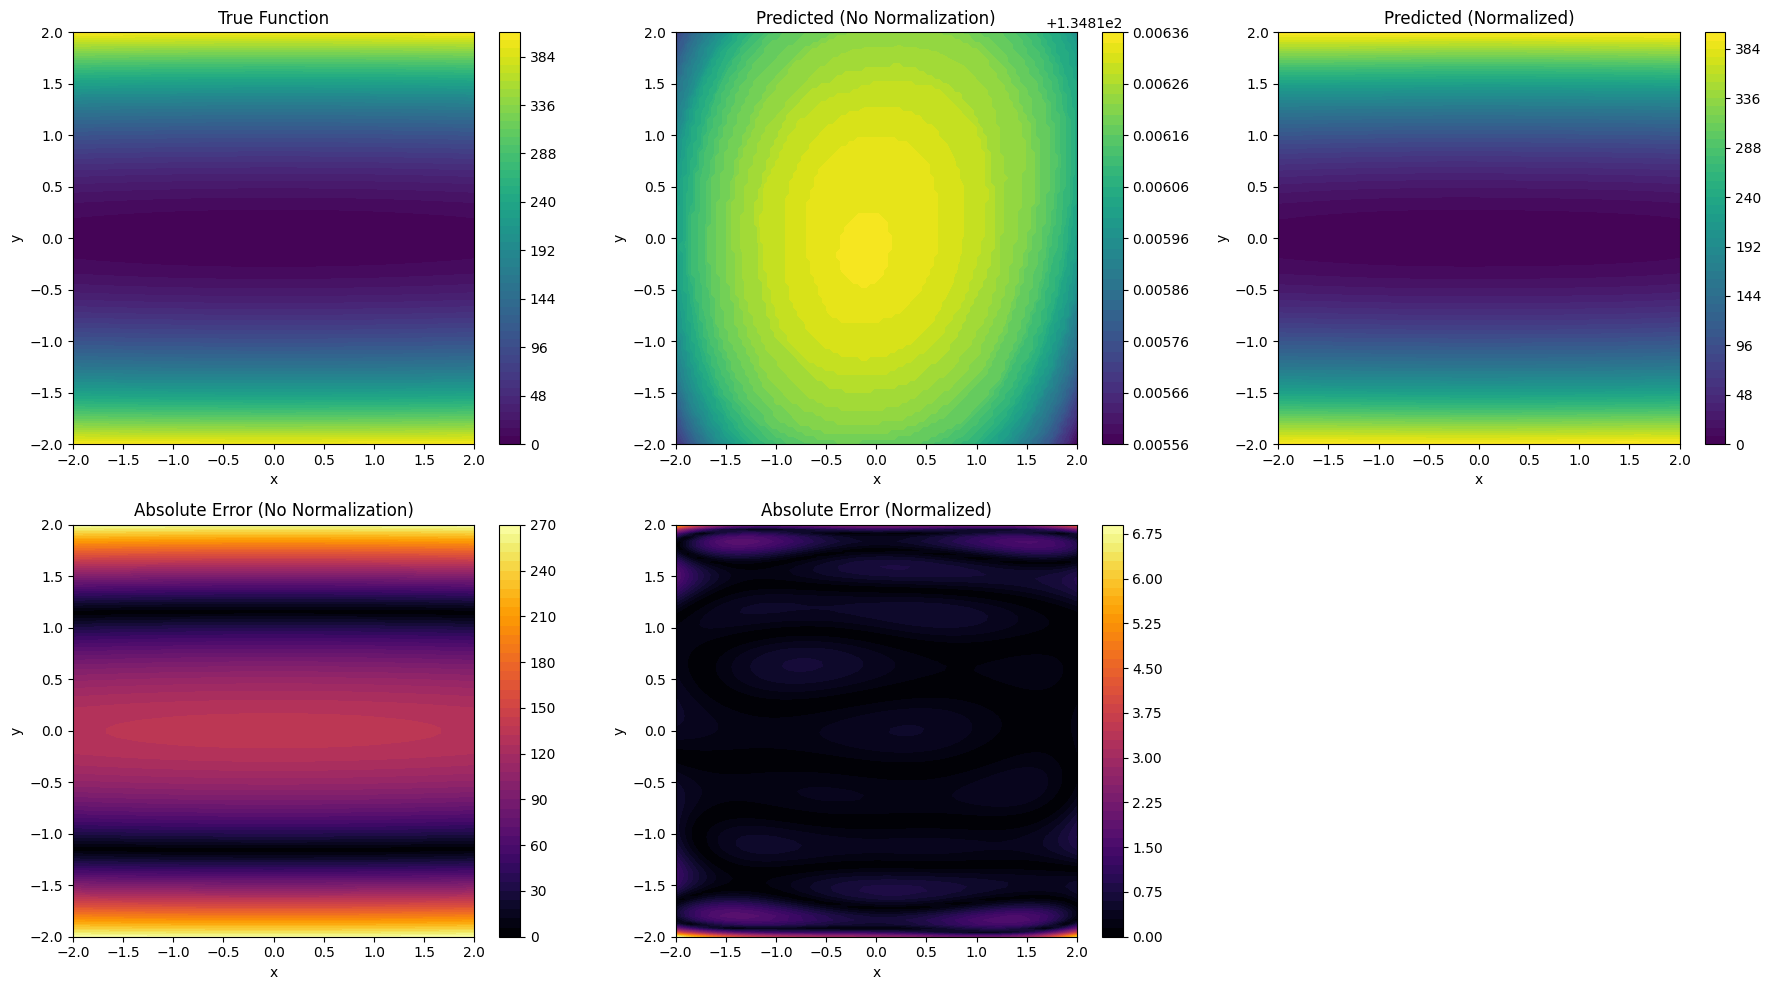

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Objective function
# -----------------------------
def objective_function(x, y, multiplier):
    return x**2 + multiplier * y**2

multiplier = 100
n_samples = 4000

# -----------------------------
# 2. Generate training data
# -----------------------------
x_data = np.random.uniform(-2, 2, n_samples)
y_data = np.random.uniform(-2, 2, n_samples)
z_data = objective_function(x_data, y_data, multiplier)

# -----------------------------
# 3. Neural network
# -----------------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

def train_network(X_tensor, Y_tensor, n_epochs=1000, lr=0.01):
    model = Net()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = criterion(output, Y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return model, losses

# -----------------------------
# 4a. Train WITHOUT normalization
# -----------------------------
X_raw = torch.tensor(np.vstack([x_data, y_data]).T, dtype=torch.float32)
Y_raw = torch.tensor(z_data.reshape(-1,1), dtype=torch.float32)
model_raw, _ = train_network(X_raw, Y_raw, n_epochs=1000, lr=0.01)
with torch.no_grad():
    pred_raw = model_raw(X_raw).numpy().flatten()

# -----------------------------
# 4b. Train WITH normalization
# -----------------------------
x_mean, x_std = x_data.mean(), x_data.std()
y_mean, y_std = y_data.mean(), y_data.std()
z_mean, z_std = z_data.mean(), z_data.std()

x_norm = (x_data - x_mean)/x_std
y_norm = (y_data - y_mean)/y_std
z_norm = (z_data - z_mean)/z_std

X_norm = torch.tensor(np.vstack([x_norm, y_norm]).T, dtype=torch.float32)
Y_norm = torch.tensor(z_norm.reshape(-1,1), dtype=torch.float32)
model_norm, _ = train_network(X_norm, Y_norm, n_epochs=1000, lr=0.01)
with torch.no_grad():
    pred_norm = model_norm(X_norm).numpy().flatten()
    pred_denorm = pred_norm * z_std + z_mean

# -----------------------------
# 5. Grid for contour
# -----------------------------
grid_points = 100
x_grid = np.linspace(-2, 2, grid_points)
y_grid = np.linspace(-2, 2, grid_points)
Xg, Yg = np.meshgrid(x_grid, y_grid)

# True function
Z_true = objective_function(Xg, Yg, multiplier)

# Predictions (raw)
Z_pred_raw = np.zeros_like(Z_true)
for i in range(grid_points):
    for j in range(grid_points):
        inp = torch.tensor([[Xg[i,j], Yg[i,j]]], dtype=torch.float32)
        Z_pred_raw[i,j] = model_raw(inp).item()

# Predictions (normalized)
Xg_norm = (Xg - x_mean)/x_std
Yg_norm = (Yg - y_mean)/y_std
Z_pred_norm = np.zeros_like(Z_true)
for i in range(grid_points):
    for j in range(grid_points):
        inp = torch.tensor([[Xg_norm[i,j], Yg_norm[i,j]]], dtype=torch.float32)
        Z_pred_norm[i,j] = model_norm(inp).item() * z_std + z_mean

# -----------------------------
# 6. Compute absolute error
# -----------------------------
error_raw = np.abs(Z_pred_raw - Z_true)
error_norm = np.abs(Z_pred_norm - Z_true)

# -----------------------------
# 7. Plot contours
# -----------------------------
fig, axs = plt.subplots(2, 3, figsize=(18,10))

# Row 1: True and predictions
cs0 = axs[0,0].contourf(Xg, Yg, Z_true, levels=50, cmap='viridis')
axs[0,0].set_title("True Function")
fig.colorbar(cs0, ax=axs[0,0])

cs1 = axs[0,1].contourf(Xg, Yg, Z_pred_raw, levels=50, cmap='viridis')
axs[0,1].set_title("Predicted (No Normalization)")
fig.colorbar(cs1, ax=axs[0,1])

cs2 = axs[0,2].contourf(Xg, Yg, Z_pred_norm, levels=50, cmap='viridis')
axs[0,2].set_title("Predicted (Normalized)")
fig.colorbar(cs2, ax=axs[0,2])

# Row 2: Errors
cs3 = axs[1,0].contourf(Xg, Yg, error_raw, levels=50, cmap='inferno')
axs[1,0].set_title("Absolute Error (No Normalization)")
fig.colorbar(cs3, ax=axs[1,0])

cs4 = axs[1,1].contourf(Xg, Yg, error_norm, levels=50, cmap='inferno')
axs[1,1].set_title("Absolute Error (Normalized)")
fig.colorbar(cs4, ax=axs[1,1])

# Leave last subplot empty
axs[1,2].axis('off')

for ax in axs.flat:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

plt.tight_layout()
plt.show()
